In [ ]:

# Import necessary libraries
import pandas as pd
import numpy as np
from Bio import SeqIO
from itertools import product
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")


Libraries imported successfully


In [ ]:

# Step 1: Load the 4.0 library and examine the structure
df_4_0 = pd.read_csv('short_hybrid_competitive_4.0_designs.csv')
print(f"Loaded 4.0 library with {len(df_4_0)} designs")
print(f"\nColumns: {list(df_4_0.columns)}")
print(f"\nFirst few rows:")
print(df_4_0.head())
print(f"\nData types:")
print(df_4_0.dtypes)


Loaded 4.0 library with 621 designs

Columns: ['Scaffold', 'Loop_Position', 'Loop_Range', 'Original_Parent', 'Triple_Mutant_Parent', 'Motif', 'Motif_Length', 'Mutation_Type', 'New_Mutation_Position', 'Original_AA', 'New_AA', 'Design_Sequence', 'Passes_Novelty', 'MJ_Score']

First few rows:
  Scaffold  Loop_Position Loop_Range Original_Parent Triple_Mutant_Parent  \
0     1FNA              1      60-68       QGIIDYLSW            QGIINFLAW   
1     2QMT              2      30-38       QGIIDYLSW            QGIINFLAW   
2     2QMT              1      45-53       QGIIDYLSW            QGIINFLAW   
3     1TEN              3      26-34       QGIIDYLSW            QGIINFLAW   
4     1TEN              2      40-48       QGIIDYLSW            QGIINFLAW   

       Motif  Motif_Length Mutation_Type  New_Mutation_Position Original_AA  \
0  QGMINFLAW             9     Quadruple                      2           I   
1  QGMINFLAW             9     Quadruple                      2           I   
2  QGMINF

In [ ]:

# Step 2: Identify the top 5 unique motifs by most favorable (most negative) raw MJ score
# Get unique motifs sorted by MJ score
unique_motifs = df_4_0.groupby('Motif')['MJ_Score'].first().sort_values()
top_5_motifs = unique_motifs.head(5)

print("Top 5 Unique Motifs from 4.0 Library (by raw MJ score):")
print("="*60)
for i, (motif, score) in enumerate(top_5_motifs.items(), 1):
    print(f"{i}. {motif}: MJ Score = {score:.2f}")

# Get detailed information about these motifs
print("\n\nDetailed information for top 5 motifs:")
print("="*60)
for motif in top_5_motifs.index:
    motif_rows = df_4_0[df_4_0['Motif'] == motif]
    parent = motif_rows['Triple_Mutant_Parent'].iloc[0]
    original = motif_rows['Original_Parent'].iloc[0]
    print(f"\nMotif: {motif}")
    print(f"  Original Parent: {original}")
    print(f"  Triple Mutant Parent: {parent}")
    print(f"  MJ Score: {motif_rows['MJ_Score'].iloc[0]:.2f}")
    print(f"  Number of designs: {len(motif_rows)}")


Top 5 Unique Motifs from 4.0 Library (by raw MJ score):
1. QGMINFLAW: MJ Score = -867.53
2. QGIMNFLAW: MJ Score = -867.53
3. QGLINFLAW: MJ Score = -867.41
4. QGILNFLAW: MJ Score = -867.41
5. RGMIDFLAW: MJ Score = -861.92


Detailed information for top 5 motifs:

Motif: QGMINFLAW
  Original Parent: QGIIDYLSW
  Triple Mutant Parent: QGIINFLAW
  MJ Score: -867.53
  Number of designs: 9

Motif: QGIMNFLAW
  Original Parent: QGIIDYLSW
  Triple Mutant Parent: QGIINFLAW
  MJ Score: -867.53
  Number of designs: 9

Motif: QGLINFLAW
  Original Parent: QGIIDYLSW
  Triple Mutant Parent: QGIINFLAW
  MJ Score: -867.41
  Number of designs: 9

Motif: QGILNFLAW
  Original Parent: QGIIDYLSW
  Triple Mutant Parent: QGIINFLAW
  MJ Score: -867.41
  Number of designs: 9

Motif: RGMIDFLAW
  Original Parent: QGIIDYLSW
  Triple Mutant Parent: RGIIDFLAW
  MJ Score: -861.92
  Number of designs: 9


In [ ]:

# Step 3: Define the BLOSUM62 matrix for conservative substitutions
# BLOSUM62 matrix - we'll use a dictionary representation
# Only including amino acids relevant for protein design
BLOSUM62 = {
    'A': {'A': 4, 'R': -1, 'N': -2, 'D': -2, 'C': 0, 'Q': -1, 'E': -1, 'G': 0, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 0, 'W': -3, 'Y': -2, 'V': 0},
    'R': {'A': -1, 'R': 5, 'N': 0, 'D': -2, 'C': -3, 'Q': 1, 'E': 0, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 2, 'M': -1, 'F': -3, 'P': -2, 'S': -1, 'T': -1, 'W': -3, 'Y': -2, 'V': -3},
    'N': {'A': -2, 'R': 0, 'N': 6, 'D': 1, 'C': -3, 'Q': 0, 'E': 0, 'G': 0, 'H': 1, 'I': -3, 'L': -3, 'K': 0, 'M': -2, 'F': -3, 'P': -2, 'S': 1, 'T': 0, 'W': -4, 'Y': -2, 'V': -3},
    'D': {'A': -2, 'R': -2, 'N': 1, 'D': 6, 'C': -3, 'Q': 0, 'E': 2, 'G': -1, 'H': -1, 'I': -3, 'L': -4, 'K': -1, 'M': -3, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -4, 'Y': -3, 'V': -3},
    'C': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': 9, 'Q': -3, 'E': -4, 'G': -3, 'H': -3, 'I': -1, 'L': -1, 'K': -3, 'M': -1, 'F': -2, 'P': -3, 'S': -1, 'T': -1, 'W': -2, 'Y': -2, 'V': -1},
    'Q': {'A': -1, 'R': 1, 'N': 0, 'D': 0, 'C': -3, 'Q': 5, 'E': 2, 'G': -2, 'H': 0, 'I': -3, 'L': -2, 'K': 1, 'M': 0, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -2, 'Y': -1, 'V': -2},
    'E': {'A': -1, 'R': 0, 'N': 0, 'D': 2, 'C': -4, 'Q': 2, 'E': 5, 'G': -2, 'H': 0, 'I': -3, 'L': -3, 'K': 1, 'M': -2, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'G': {'A': 0, 'R': -2, 'N': 0, 'D': -1, 'C': -3, 'Q': -2, 'E': -2, 'G': 6, 'H': -2, 'I': -4, 'L': -4, 'K': -2, 'M': -3, 'F': -3, 'P': -2, 'S': 0, 'T': -2, 'W': -2, 'Y': -3, 'V': -3},
    'H': {'A': -2, 'R': 0, 'N': 1, 'D': -1, 'C': -3, 'Q': 0, 'E': 0, 'G': -2, 'H': 8, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -1, 'P': -2, 'S': -1, 'T': -2, 'W': -2, 'Y': 2, 'V': -3},
    'I': {'A': -1, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -3, 'E': -3, 'G': -4, 'H': -3, 'I': 4, 'L': 2, 'K': -3, 'M': 1, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -3, 'Y': -1, 'V': 3},
    'L': {'A': -1, 'R': -2, 'N': -3, 'D': -4, 'C': -1, 'Q': -2, 'E': -3, 'G': -4, 'H': -3, 'I': 2, 'L': 4, 'K': -2, 'M': 2, 'F': 0, 'P': -3, 'S': -2, 'T': -1, 'W': -2, 'Y': -1, 'V': 1},
    'K': {'A': -1, 'R': 2, 'N': 0, 'D': -1, 'C': -3, 'Q': 1, 'E': 1, 'G': -2, 'H': -1, 'I': -3, 'L': -2, 'K': 5, 'M': -1, 'F': -3, 'P': -1, 'S': 0, 'T': -1, 'W': -3, 'Y': -2, 'V': -2},
    'M': {'A': -1, 'R': -1, 'N': -2, 'D': -3, 'C': -1, 'Q': 0, 'E': -2, 'G': -3, 'H': -2, 'I': 1, 'L': 2, 'K': -1, 'M': 5, 'F': 0, 'P': -2, 'S': -1, 'T': -1, 'W': -1, 'Y': -1, 'V': 1},
    'F': {'A': -2, 'R': -3, 'N': -3, 'D': -3, 'C': -2, 'Q': -3, 'E': -3, 'G': -3, 'H': -1, 'I': 0, 'L': 0, 'K': -3, 'M': 0, 'F': 6, 'P': -4, 'S': -2, 'T': -2, 'W': 1, 'Y': 3, 'V': -1},
    'P': {'A': -1, 'R': -2, 'N': -2, 'D': -1, 'C': -3, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -3, 'L': -3, 'K': -1, 'M': -2, 'F': -4, 'P': 7, 'S': -1, 'T': -1, 'W': -4, 'Y': -3, 'V': -2},
    'S': {'A': 1, 'R': -1, 'N': 1, 'D': 0, 'C': -1, 'Q': 0, 'E': 0, 'G': 0, 'H': -1, 'I': -2, 'L': -2, 'K': 0, 'M': -1, 'F': -2, 'P': -1, 'S': 4, 'T': 1, 'W': -3, 'Y': -2, 'V': -2},
    'T': {'A': 0, 'R': -1, 'N': 0, 'D': -1, 'C': -1, 'Q': -1, 'E': -1, 'G': -2, 'H': -2, 'I': -1, 'L': -1, 'K': -1, 'M': -1, 'F': -2, 'P': -1, 'S': 1, 'T': 5, 'W': -2, 'Y': -2, 'V': 0},
    'W': {'A': -3, 'R': -3, 'N': -4, 'D': -4, 'C': -2, 'Q': -2, 'E': -3, 'G': -2, 'H': -2, 'I': -3, 'L': -2, 'K': -3, 'M': -1, 'F': 1, 'P': -4, 'S': -3, 'T': -2, 'W': 11, 'Y': 2, 'V': -3},
    'Y': {'A': -2, 'R': -2, 'N': -2, 'D': -3, 'C': -2, 'Q': -1, 'E': -2, 'G': -3, 'H': 2, 'I': -1, 'L': -1, 'K': -2, 'M': -1, 'F': 3, 'P': -3, 'S': -2, 'T': -2, 'W': 2, 'Y': 7, 'V': -1},
    'V': {'A': 0, 'R': -3, 'N': -3, 'D': -3, 'C': -1, 'Q': -2, 'E': -2, 'G': -3, 'H': -3, 'I': 3, 'L': 1, 'K': -2, 'M': 1, 'F': -1, 'P': -2, 'S': -2, 'T': 0, 'W': -3, 'Y': -1, 'V': 4},
}

# Function to get conservative substitutions (BLOSUM62 > 0)
def get_conservative_substitutions(aa):
    """Return list of amino acids with BLOSUM62 > 0 for given amino acid"""
    if aa not in BLOSUM62:
        return []
    return [new_aa for new_aa, score in BLOSUM62[aa].items() if score > 0 and new_aa != aa]

print("BLOSUM62 matrix loaded successfully")
print("\nExample conservative substitutions:")
for aa in ['Q', 'G', 'I', 'N', 'F', 'L', 'A', 'W']:
    subs = get_conservative_substitutions(aa)
    print(f"  {aa} -> {subs}")


BLOSUM62 matrix loaded successfully

Example conservative substitutions:
  Q -> ['R', 'E', 'K']
  G -> []
  I -> ['L', 'M', 'V']
  N -> ['D', 'H', 'S']
  F -> ['W', 'Y']
  L -> ['I', 'M', 'V']
  A -> ['S']
  W -> ['F', 'Y']


In [ ]:

# Step 4: Track mutation history for each top motif
# We need to identify which positions have already been mutated to avoid mutating them again
print("Analyzing mutation history for each top 5 motif:")
print("="*80)

mutation_history = {}

for motif in top_5_motifs.index:
    motif_rows = df_4_0[df_4_0['Motif'] == motif]
    original = motif_rows['Original_Parent'].iloc[0]
    triple_parent = motif_rows['Triple_Mutant_Parent'].iloc[0]
    
    # Identify all mutated positions by comparing original to current motif
    mutated_positions = []
    for i, (orig_aa, motif_aa) in enumerate(zip(original, motif)):
        if orig_aa != motif_aa:
            mutated_positions.append(i)
    
    # Also identify available positions (non-mutated)
    available_positions = [i for i in range(len(motif)) if i not in mutated_positions]
    
    mutation_history[motif] = {
        'original': original,
        'triple_parent': triple_parent,
        'mutated_positions': mutated_positions,
        'available_positions': available_positions
    }
    
    print(f"\nMotif: {motif}")
    print(f"  Original:      {original}")
    print(f"  Triple Parent: {triple_parent}")
    print(f"  Current:       {motif}")
    print(f"  Mutated positions: {mutated_positions}")
    print(f"  Available positions for 5th mutation: {available_positions}")
    
    # Show what residues are at available positions
    available_residues = [(i, motif[i]) for i in available_positions]
    print(f"  Available residues: {available_residues}")


Analyzing mutation history for each top 5 motif:

Motif: QGMINFLAW
  Original:      QGIIDYLSW
  Triple Parent: QGIINFLAW
  Current:       QGMINFLAW
  Mutated positions: [2, 4, 5, 7]
  Available positions for 5th mutation: [0, 1, 3, 6, 8]
  Available residues: [(0, 'Q'), (1, 'G'), (3, 'I'), (6, 'L'), (8, 'W')]

Motif: QGIMNFLAW
  Original:      QGIIDYLSW
  Triple Parent: QGIINFLAW
  Current:       QGIMNFLAW
  Mutated positions: [3, 4, 5, 7]
  Available positions for 5th mutation: [0, 1, 2, 6, 8]
  Available residues: [(0, 'Q'), (1, 'G'), (2, 'I'), (6, 'L'), (8, 'W')]

Motif: QGLINFLAW
  Original:      QGIIDYLSW
  Triple Parent: QGIINFLAW
  Current:       QGLINFLAW
  Mutated positions: [2, 4, 5, 7]
  Available positions for 5th mutation: [0, 1, 3, 6, 8]
  Available residues: [(0, 'Q'), (1, 'G'), (3, 'I'), (6, 'L'), (8, 'W')]

Motif: QGILNFLAW
  Original:      QGIIDYLSW
  Triple Parent: QGIINFLAW
  Current:       QGILNFLAW
  Mutated positions: [3, 4, 5, 7]
  Available positions for 5th mu

In [ ]:

# Step 5: Generate all quintuple mutants for each top 5 motif
print("Generating quintuple mutants for each top 5 motif:")
print("="*80)

quintuple_mutants = []

for motif in top_5_motifs.index:
    history = mutation_history[motif]
    print(f"\nProcessing motif: {motif}")
    
    # For each available (non-mutated) position
    for pos in history['available_positions']:
        current_aa = motif[pos]
        
        # Get conservative substitutions for this amino acid
        substitutions = get_conservative_substitutions(current_aa)
        
        if not substitutions:
            print(f"  Position {pos} ({current_aa}): No conservative substitutions available (skipped)")
            continue
        
        print(f"  Position {pos} ({current_aa}): {len(substitutions)} conservative substitutions: {substitutions}")
        
        # Generate a quintuple mutant for each substitution
        for new_aa in substitutions:
            # Create the new motif sequence
            new_motif = list(motif)
            new_motif[pos] = new_aa
            new_motif_str = ''.join(new_motif)
            
            quintuple_mutants.append({
                'Quadruple_Parent': motif,
                'Triple_Parent': history['triple_parent'],
                'Original_Parent': history['original'],
                'New_Motif': new_motif_str,
                'Fifth_Mutation_Position': pos,
                'Fifth_Original_AA': current_aa,
                'Fifth_New_AA': new_aa,
                'Motif_Length': len(new_motif_str)
            })

print(f"\n{'='*80}")
print(f"Total quintuple mutants generated: {len(quintuple_mutants)}")
print(f"\nFirst 10 examples:")
for i, mutant in enumerate(quintuple_mutants[:10]):
    print(f"  {i+1}. {mutant['Quadruple_Parent']} -> {mutant['New_Motif']} (pos {mutant['Fifth_Mutation_Position']}: {mutant['Fifth_Original_AA']}->{mutant['Fifth_New_AA']})")


Generating quintuple mutants for each top 5 motif:

Processing motif: QGMINFLAW
  Position 0 (Q): 3 conservative substitutions: ['R', 'E', 'K']
  Position 1 (G): No conservative substitutions available (skipped)
  Position 3 (I): 3 conservative substitutions: ['L', 'M', 'V']
  Position 6 (L): 3 conservative substitutions: ['I', 'M', 'V']
  Position 8 (W): 2 conservative substitutions: ['F', 'Y']

Processing motif: QGIMNFLAW
  Position 0 (Q): 3 conservative substitutions: ['R', 'E', 'K']
  Position 1 (G): No conservative substitutions available (skipped)
  Position 2 (I): 3 conservative substitutions: ['L', 'M', 'V']
  Position 6 (L): 3 conservative substitutions: ['I', 'M', 'V']
  Position 8 (W): 2 conservative substitutions: ['F', 'Y']

Processing motif: QGLINFLAW
  Position 0 (Q): 3 conservative substitutions: ['R', 'E', 'K']
  Position 1 (G): No conservative substitutions available (skipped)
  Position 3 (I): 3 conservative substitutions: ['L', 'M', 'V']
  Position 6 (L): 3 conserva

In [ ]:

# Step 6 (revised): Use sequences from the 4.0 library to extract scaffold sequences
# We can get the scaffold sequences by examining designs from the 4.0 library

scaffold_sequences = {}
scaffold_loop_info = {}

for scaffold_id in ['1FNA', '1TEN', '2QMT']:
    # Get a design with this scaffold
    scaffold_designs = df_4_0[df_4_0['Scaffold'] == scaffold_id]
    
    if len(scaffold_designs) > 0:
        # Get all unique loop positions for this scaffold
        loop_positions = scaffold_designs['Loop_Position'].unique()
        
        # For each loop position, get the range and reconstruct the scaffold sequence
        # We'll use the design sequences to back out the scaffold sequence
        sample_design = scaffold_designs.iloc[0]
        scaffold_sequences[scaffold_id] = sample_design['Design_Sequence']
        
        # Store loop information
        scaffold_loop_info[scaffold_id] = {}
        for loop_pos in sorted(loop_positions):
            loop_designs = scaffold_designs[scaffold_designs['Loop_Position'] == loop_pos]
            loop_range = loop_designs['Loop_Range'].iloc[0]
            scaffold_loop_info[scaffold_id][loop_pos] = loop_range
        
        print(f"{scaffold_id}: {len(scaffold_sequences[scaffold_id])} residues")
        print(f"  Loop positions: {sorted(loop_positions)}")
        print(f"  Loop ranges: {scaffold_loop_info[scaffold_id]}")

print("\nScaffold sequences extracted from 4.0 library")


1FNA: 89 residues
  Loop positions: [np.int64(1), np.int64(2), np.int64(3)]
  Loop ranges: {np.int64(1): '60-68', np.int64(2): '50-58', np.int64(3): '35-43'}
1TEN: 99 residues
  Loop positions: [np.int64(1), np.int64(2), np.int64(3)]
  Loop ranges: {np.int64(1): '56-64', np.int64(2): '40-48', np.int64(3): '26-34'}
2QMT: 56 residues
  Loop positions: [np.int64(1), np.int64(2), np.int64(3)]
  Loop ranges: {np.int64(1): '45-53', np.int64(2): '30-38', np.int64(3): '17-25'}

Scaffold sequences extracted from 4.0 library


In [ ]:

# Step 7: For each quintuple mutant, graft onto all three scaffolds at all loop positions
# We need to properly extract scaffold base sequences and graft motifs

all_designs = []

for scaffold_id in ['1FNA', '1TEN', '2QMT']:
    # Get scaffold designs to understand the grafting process
    scaffold_designs = df_4_0[df_4_0['Scaffold'] == scaffold_id]
    
    for loop_pos in sorted(scaffold_designs['Loop_Position'].unique()):
        # Get a reference design with this scaffold and loop position
        ref_design = scaffold_designs[scaffold_designs['Loop_Position'] == loop_pos].iloc[0]
        ref_motif = ref_design['Motif']
        ref_sequence = ref_design['Design_Sequence']
        loop_range = ref_design['Loop_Range']
        
        # Parse loop range (e.g., "60-68")
        start_pos, end_pos = map(int, loop_range.split('-'))
        # Convert to 0-indexed
        start_idx = start_pos - 1
        end_idx = end_pos  # end_pos is inclusive in the range, so we don't subtract 1
        
        # Extract the motif from the reference design
        ref_motif_in_seq = ref_sequence[start_idx:end_idx]
        
        # Verify this matches the expected motif
        if ref_motif_in_seq != ref_motif:
            print(f"Warning: motif mismatch for {scaffold_id} loop {loop_pos}")
            print(f"  Expected: {ref_motif}")
            print(f"  Found: {ref_motif_in_seq}")
            print(f"  Range: {loop_range} (indices {start_idx}:{end_idx})")
        
        # Extract scaffold base (everything except the motif)
        scaffold_base = ref_sequence[:start_idx] + ref_sequence[end_idx:]
        
        # Now graft each quintuple mutant into this scaffold/loop combination
        for mutant in quintuple_mutants:
            new_motif = mutant['New_Motif']
            
            # Create the new design sequence
            design_sequence = ref_sequence[:start_idx] + new_motif + ref_sequence[end_idx:]
            
            all_designs.append({
                'Scaffold': scaffold_id,
                'Loop_Position': loop_pos,
                'Loop_Range': loop_range,
                'Original_Parent': mutant['Original_Parent'],
                'Triple_Parent': mutant['Triple_Parent'],
                'Quadruple_Parent': mutant['Quadruple_Parent'],
                'Motif': new_motif,
                'Motif_Length': mutant['Motif_Length'],
                'Mutation_Type': 'Quintuple',
                'Fifth_Mutation_Position': mutant['Fifth_Mutation_Position'],
                'Fifth_Original_AA': mutant['Fifth_Original_AA'],
                'Fifth_New_AA': mutant['Fifth_New_AA'],
                'Design_Sequence': design_sequence
            })

print(f"Generated {len(all_designs)} total designs")
print(f"  {len(quintuple_mutants)} unique motifs × {len(['1FNA', '1TEN', '2QMT'])} scaffolds × multiple loop positions")
print(f"\nFirst design example:")
print(all_designs[0])


Generated 486 total designs
  54 unique motifs × 3 scaffolds × multiple loop positions

First design example:
{'Scaffold': '1FNA', 'Loop_Position': np.int64(1), 'Loop_Range': '60-68', 'Original_Parent': 'QGIIDYLSW', 'Triple_Parent': 'QGIINFLAW', 'Quadruple_Parent': 'QGMINFLAW', 'Motif': 'RGMINFLAW', 'Motif_Length': 9, 'Mutation_Type': 'Quintuple', 'Fifth_Mutation_Position': 0, 'Fifth_Original_AA': 'Q', 'Fifth_New_AA': 'R', 'Design_Sequence': 'RDLEVVAATPTSLLISWDAPAVTVRYYRITYGETGGNSPVQEFTVPGSKSTATISGLKPRGMINFLAWAVTGRGDSPASSKPISINYRT'}


In [ ]:

# Step 8: Load novelty filter sequences (known binders and CDR library)
# Load known binders
known_binders = []
with open('known_niv_binders_full.fasta', 'r') as f:
    for record in SeqIO.parse(f, 'fasta'):
        known_binders.append(str(record.seq))

print(f"Loaded {len(known_binders)} known binder sequences")

# Load CDR library
cdr_df = pd.read_csv('cdr_library_summary.csv')
cdr_sequences = cdr_df['Sequence'].tolist()
print(f"Loaded {len(cdr_sequences)} CDR sequences")

# Combine all sequences to check against
novelty_check_sequences = known_binders + cdr_sequences
print(f"Total sequences for novelty checking: {len(novelty_check_sequences)}")


Loaded 6 known binder sequences
Loaded 12 CDR sequences
Total sequences for novelty checking: 18


In [ ]:

# Step 9: Apply novelty filter - check for 10-AA sliding window matches
def check_novelty(design_sequence, reference_sequences, window_size=10):
    """
    Check if design passes novelty filter.
    Returns True if NO 10-AA window matches 100% with any reference sequence.
    """
    design_len = len(design_sequence)
    
    # Generate all 10-AA windows from the design
    for i in range(design_len - window_size + 1):
        window = design_sequence[i:i+window_size]
        
        # Check if this window exists in any reference sequence
        for ref_seq in reference_sequences:
            if window in ref_seq:
                return False  # Found a match, fails novelty
    
    return True  # No matches found, passes novelty

print("Applying novelty filter to all designs...")
print(f"Checking {len(all_designs)} designs against {len(novelty_check_sequences)} reference sequences")

# Apply filter
novel_designs = []
non_novel_designs = []

for design in all_designs:
    passes = check_novelty(design['Design_Sequence'], novelty_check_sequences)
    design['Passes_Novelty'] = passes
    
    if passes:
        novel_designs.append(design)
    else:
        non_novel_designs.append(design)

print(f"\nResults:")
print(f"  Novel designs (pass filter): {len(novel_designs)}")
print(f"  Non-novel designs (fail filter): {len(non_novel_designs)}")
print(f"  Pass rate: {100*len(novel_designs)/len(all_designs):.1f}%")


Applying novelty filter to all designs...
Checking 486 designs against 18 reference sequences

Results:
  Novel designs (pass filter): 486
  Non-novel designs (fail filter): 0
  Pass rate: 100.0%


In [ ]:

# Step 10: Define the Miyazawa-Jernigan (MJ) potential matrix
# MJ interaction energy matrix (in units of kT)
MJ_MATRIX = {
    'C': {'C': -5.44, 'M': -5.46, 'F': -5.80, 'I': -5.50, 'L': -5.83, 'V': -5.18, 'W': -5.83, 'Y': -5.24, 'A': -4.99, 'G': -4.48, 'T': -4.81, 'S': -4.59, 'N': -4.24, 'Q': -4.13, 'D': -4.15, 'E': -3.98, 'H': -4.62, 'R': -3.97, 'K': -3.90, 'P': -4.36},
    'M': {'C': -5.46, 'M': -5.46, 'F': -5.32, 'I': -5.22, 'L': -5.55, 'V': -4.96, 'W': -4.91, 'Y': -4.91, 'A': -4.74, 'G': -4.16, 'T': -4.41, 'S': -4.09, 'N': -4.36, 'Q': -4.27, 'D': -4.02, 'E': -3.98, 'H': -4.54, 'R': -4.24, 'K': -4.04, 'P': -4.03},
    'F': {'C': -5.80, 'M': -5.32, 'F': -5.66, 'I': -5.81, 'L': -5.68, 'V': -5.25, 'W': -5.66, 'Y': -5.43, 'A': -4.81, 'G': -4.13, 'T': -4.28, 'S': -4.13, 'N': -4.31, 'Q': -4.10, 'D': -4.13, 'E': -4.03, 'H': -4.77, 'R': -4.10, 'K': -4.16, 'P': -4.25},
    'I': {'C': -5.50, 'M': -5.22, 'F': -5.81, 'I': -5.00, 'L': -5.15, 'V': -4.91, 'W': -5.18, 'Y': -4.72, 'A': -4.58, 'G': -4.16, 'T': -4.49, 'S': -4.00, 'N': -4.17, 'Q': -4.04, 'D': -3.81, 'E': -3.87, 'H': -4.14, 'R': -3.91, 'K': -3.90, 'P': -3.76},
    'L': {'C': -5.83, 'M': -5.55, 'F': -5.68, 'I': -5.15, 'L': -5.35, 'V': -4.91, 'W': -5.40, 'Y': -4.98, 'A': -4.91, 'G': -4.16, 'T': -4.34, 'S': -4.07, 'N': -4.19, 'Q': -4.04, 'D': -4.03, 'E': -3.91, 'H': -4.27, 'R': -4.03, 'K': -3.92, 'P': -3.98},
    'V': {'C': -5.18, 'M': -4.96, 'F': -5.25, 'I': -4.91, 'L': -4.91, 'V': -4.58, 'W': -4.98, 'Y': -4.62, 'A': -4.64, 'G': -3.98, 'T': -4.56, 'S': -4.16, 'N': -4.00, 'Q': -3.98, 'D': -3.76, 'E': -3.77, 'H': -4.03, 'R': -3.87, 'K': -3.92, 'P': -3.61},
    'W': {'C': -5.83, 'M': -4.91, 'F': -5.66, 'I': -5.18, 'L': -5.40, 'V': -4.98, 'W': -5.55, 'Y': -5.18, 'A': -4.72, 'G': -4.39, 'T': -4.34, 'S': -3.98, 'N': -4.95, 'Q': -4.37, 'D': -4.25, 'E': -3.98, 'H': -4.98, 'R': -4.43, 'K': -3.94, 'P': -4.25},
    'Y': {'C': -5.24, 'M': -4.91, 'F': -5.43, 'I': -4.72, 'L': -4.98, 'V': -4.62, 'W': -5.18, 'Y': -5.28, 'A': -4.17, 'G': -4.13, 'T': -4.21, 'S': -3.72, 'N': -4.11, 'Q': -4.21, 'D': -3.72, 'E': -3.72, 'H': -4.62, 'R': -3.87, 'K': -3.94, 'P': -3.98},
    'A': {'C': -4.99, 'M': -4.74, 'F': -4.81, 'I': -4.58, 'L': -4.91, 'V': -4.64, 'W': -4.72, 'Y': -4.17, 'A': -4.17, 'G': -4.07, 'T': -4.03, 'S': -3.95, 'N': -3.87, 'Q': -3.87, 'D': -3.61, 'E': -3.63, 'H': -3.94, 'R': -3.87, 'K': -3.78, 'P': -3.46},
    'G': {'C': -4.48, 'M': -4.16, 'F': -4.13, 'I': -4.16, 'L': -4.16, 'V': -3.98, 'W': -4.39, 'Y': -4.13, 'A': -4.07, 'G': -3.63, 'T': -3.63, 'S': -3.72, 'N': -3.72, 'Q': -3.59, 'D': -3.59, 'E': -3.50, 'H': -3.87, 'R': -3.59, 'K': -3.63, 'P': -3.16},
    'T': {'C': -4.81, 'M': -4.41, 'F': -4.28, 'I': -4.49, 'L': -4.34, 'V': -4.56, 'W': -4.34, 'Y': -4.21, 'A': -4.03, 'G': -3.63, 'T': -4.21, 'S': -3.72, 'N': -3.59, 'Q': -3.85, 'D': -3.72, 'E': -3.59, 'H': -3.85, 'R': -3.72, 'K': -3.63, 'P': -3.37},
    'S': {'C': -4.59, 'M': -4.09, 'F': -4.13, 'I': -4.00, 'L': -4.07, 'V': -4.16, 'W': -3.98, 'Y': -3.72, 'A': -3.95, 'G': -3.72, 'T': -3.72, 'S': -3.40, 'N': -3.59, 'Q': -3.55, 'D': -3.37, 'E': -3.16, 'H': -3.72, 'R': -3.46, 'K': -3.46, 'P': -3.07},
    'N': {'C': -4.24, 'M': -4.36, 'F': -4.31, 'I': -4.17, 'L': -4.19, 'V': -4.00, 'W': -4.95, 'Y': -4.11, 'A': -3.87, 'G': -3.72, 'T': -3.59, 'S': -3.59, 'N': -3.46, 'Q': -3.72, 'D': -3.46, 'E': -3.24, 'H': -4.00, 'R': -3.72, 'K': -3.85, 'P': -3.24},
    'Q': {'C': -4.13, 'M': -4.27, 'F': -4.10, 'I': -4.04, 'L': -4.04, 'V': -3.98, 'W': -4.37, 'Y': -4.21, 'A': -3.87, 'G': -3.59, 'T': -3.85, 'S': -3.55, 'N': -3.72, 'Q': -3.53, 'D': -3.46, 'E': -3.07, 'H': -3.98, 'R': -3.63, 'K': -3.37, 'P': -3.24},
    'D': {'C': -4.15, 'M': -4.02, 'F': -4.13, 'I': -3.81, 'L': -4.03, 'V': -3.76, 'W': -4.25, 'Y': -3.72, 'A': -3.61, 'G': -3.59, 'T': -3.72, 'S': -3.37, 'N': -3.46, 'Q': -3.46, 'D': -2.84, 'E': -2.87, 'H': -3.98, 'R': -3.46, 'K': -3.07, 'P': -2.84},
    'E': {'C': -3.98, 'M': -3.98, 'F': -4.03, 'I': -3.87, 'L': -3.91, 'V': -3.77, 'W': -3.98, 'Y': -3.72, 'A': -3.63, 'G': -3.50, 'T': -3.59, 'S': -3.16, 'N': -3.24, 'Q': -3.07, 'D': -2.87, 'E': -2.67, 'H': -3.50, 'R': -3.24, 'K': -3.07, 'P': -2.76},
    'H': {'C': -4.62, 'M': -4.54, 'F': -4.77, 'I': -4.14, 'L': -4.27, 'V': -4.03, 'W': -4.98, 'Y': -4.62, 'A': -3.94, 'G': -3.87, 'T': -3.85, 'S': -3.72, 'N': -4.00, 'Q': -3.98, 'D': -3.98, 'E': -3.50, 'H': -4.16, 'R': -3.72, 'K': -3.67, 'P': -3.40},
    'R': {'C': -3.97, 'M': -4.24, 'F': -4.10, 'I': -3.91, 'L': -4.03, 'V': -3.87, 'W': -4.43, 'Y': -3.87, 'A': -3.87, 'G': -3.59, 'T': -3.72, 'S': -3.46, 'N': -3.72, 'Q': -3.63, 'D': -3.46, 'E': -3.24, 'H': -3.72, 'R': -3.46, 'K': -2.76, 'P': -2.90},
    'K': {'C': -3.90, 'M': -4.04, 'F': -4.16, 'I': -3.90, 'L': -3.92, 'V': -3.92, 'W': -3.94, 'Y': -3.94, 'A': -3.78, 'G': -3.63, 'T': -3.63, 'S': -3.46, 'N': -3.85, 'Q': -3.37, 'D': -3.07, 'E': -3.07, 'H': -3.67, 'R': -2.76, 'K': -2.95, 'P': -2.69},
    'P': {'C': -4.36, 'M': -4.03, 'F': -4.25, 'I': -3.76, 'L': -3.98, 'V': -3.61, 'W': -4.25, 'Y': -3.98, 'A': -3.46, 'G': -3.16, 'T': -3.37, 'S': -3.07, 'N': -3.24, 'Q': -3.24, 'D': -2.84, 'E': -2.76, 'H': -3.40, 'R': -2.90, 'K': -2.69, 'P': -2.70}
}

# Define the competitive epitope (20 residues)
COMPETITIVE_EPITOPE = 'SCSRGVSKQRIIGVGEVLDR'

# Function to calculate raw MJ score
def calculate_raw_mj_score(motif, epitope):
    """
    Calculate the raw MJ interaction score between a motif and epitope.
    Sum of all pairwise MJ energies between motif and epitope residues.
    """
    total_score = 0.0
    
    for motif_aa in motif:
        for epitope_aa in epitope:
            # Get MJ interaction energy
            if motif_aa in MJ_MATRIX and epitope_aa in MJ_MATRIX[motif_aa]:
                total_score += MJ_MATRIX[motif_aa][epitope_aa]
    
    return total_score

print("MJ matrix loaded successfully")
print(f"Competitive epitope: {COMPETITIVE_EPITOPE} ({len(COMPETITIVE_EPITOPE)} residues)")


MJ matrix loaded successfully
Competitive epitope: SCSRGVSKQRIIGVGEVLDR (20 residues)


In [ ]:

# Step 11: Calculate raw MJ scores for all novel designs
print("Calculating raw MJ scores for all novel designs...")

for design in novel_designs:
    motif = design['Motif']
    mj_score = calculate_raw_mj_score(motif, COMPETITIVE_EPITOPE)
    design['MJ_Score'] = mj_score

# Create DataFrame
df_5_0 = pd.DataFrame(novel_designs)

# Sort by MJ score (most negative = most favorable)
df_5_0 = df_5_0.sort_values('MJ_Score')

print(f"\nCalculated MJ scores for {len(df_5_0)} designs")
print(f"\nTop 10 designs by MJ score:")
print(df_5_0[['Motif', 'Quadruple_Parent', 'Fifth_New_AA', 'MJ_Score', 'Scaffold', 'Loop_Position']].head(10))

print(f"\nMJ score statistics for 5.0 library:")
print(f"  Mean: {df_5_0['MJ_Score'].mean():.2f}")
print(f"  Median: {df_5_0['MJ_Score'].median():.2f}")
print(f"  Min (best): {df_5_0['MJ_Score'].min():.2f}")
print(f"  Max (worst): {df_5_0['MJ_Score'].max():.2f}")
print(f"  Std: {df_5_0['MJ_Score'].std():.2f}")


Calculating raw MJ scores for all novel designs...

Calculated MJ scores for 486 designs

Top 10 designs by MJ score:
         Motif Quadruple_Parent Fifth_New_AA  MJ_Score Scaffold  Loop_Position
393  QGMMNFLAW        QGIMNFLAW            M   -762.56     2QMT              2
112  QGMMNFLAW        QGMINFLAW            M   -762.56     1FNA              3
4    QGMMNFLAW        QGMINFLAW            M   -762.56     1FNA              1
285  QGMMNFLAW        QGIMNFLAW            M   -762.56     1TEN              3
123  QGMMNFLAW        QGIMNFLAW            M   -762.56     1FNA              3
220  QGMMNFLAW        QGMINFLAW            M   -762.56     1TEN              2
274  QGMMNFLAW        QGMINFLAW            M   -762.56     1TEN              3
231  QGMMNFLAW        QGIMNFLAW            M   -762.56     1TEN              2
166  QGMMNFLAW        QGMINFLAW            M   -762.56     1TEN              1
382  QGMMNFLAW        QGMINFLAW            M   -762.56     2QMT              2

MJ score sta

In [ ]:

# Step 12: Get parent quadruple motif scores for comparison
# We need to get the MJ scores of the top 5 quadruple parent motifs from 4.0 library

parent_scores = []
for motif in top_5_motifs.index:
    parent_score = top_5_motifs[motif]
    parent_scores.append(parent_score)

print("Parent Quadruple Motif Scores (from 4.0 library):")
print("="*60)
for motif, score in zip(top_5_motifs.index, parent_scores):
    print(f"  {motif}: {score:.2f}")

print(f"\nParent score statistics:")
print(f"  Mean: {np.mean(parent_scores):.2f}")
print(f"  Median: {np.median(parent_scores):.2f}")
print(f"  Min (best): {np.min(parent_scores):.2f}")
print(f"  Max (worst): {np.max(parent_scores):.2f}")
print(f"  Std: {np.std(parent_scores):.2f}")

# Get scores for all designs derived from each parent
print("\n\nQuintuple mutant score statistics by parent motif:")
print("="*60)
for parent_motif in top_5_motifs.index:
    child_designs = df_5_0[df_5_0['Quadruple_Parent'] == parent_motif]
    child_scores = child_designs['MJ_Score'].values
    
    print(f"\nParent: {parent_motif} (score: {top_5_motifs[parent_motif]:.2f})")
    print(f"  Number of quintuple children: {len(child_scores)}")
    print(f"  Child score range: [{child_scores.min():.2f}, {child_scores.max():.2f}]")
    print(f"  Child score mean: {child_scores.mean():.2f}")
    print(f"  Best improvement: {child_scores.min() - top_5_motifs[parent_motif]:.2f}")


Parent Quadruple Motif Scores (from 4.0 library):
  QGMINFLAW: -867.53
  QGIMNFLAW: -867.53
  QGLINFLAW: -867.41
  QGILNFLAW: -867.41
  RGMIDFLAW: -861.92

Parent score statistics:
  Mean: -866.36
  Median: -867.41
  Min (best): -867.53
  Max (worst): -861.92
  Std: 2.22


Quintuple mutant score statistics by parent motif:

Parent: QGMINFLAW (score: -867.53)
  Number of quintuple children: 99
  Child score range: [-762.56, -752.46]
  Child score mean: -757.83
  Best improvement: 104.97

Parent: QGIMNFLAW (score: -867.53)
  Number of quintuple children: 99
  Child score range: [-762.56, -752.46]
  Child score mean: -757.83
  Best improvement: 104.97

Parent: QGLINFLAW (score: -867.41)
  Number of quintuple children: 99
  Child score range: [-761.34, -751.24]
  Child score mean: -756.61
  Best improvement: 106.07

Parent: QGILNFLAW (score: -867.41)
  Number of quintuple children: 99
  Child score range: [-761.34, -751.24]
  Child score mean: -756.61
  Best improvement: 106.07

Parent: RG

In [ ]:

# Step 13: Understand the unexpected result - the quintuple mutants have WORSE scores than parents
# This is the opposite of what we expected. Let's investigate why.

print("CRITICAL FINDING: Quintuple mutants have WORSE (less negative) MJ scores than parents!")
print("="*80)
print("\nComparison:")
print(f"  Parent 4.0 library mean score: {np.mean(parent_scores):.2f}")
print(f"  Child 5.0 library mean score: {df_5_0['MJ_Score'].mean():.2f}")
print(f"  Difference (child - parent): {df_5_0['MJ_Score'].mean() - np.mean(parent_scores):.2f}")
print(f"  This represents a DETERIORATION of {abs(df_5_0['MJ_Score'].mean() - np.mean(parent_scores)):.2f} units")

print("\n\nBest parent vs. best child:")
print(f"  Best parent score: {np.min(parent_scores):.2f}")
print(f"  Best child score: {df_5_0['MJ_Score'].min():.2f}")
print(f"  Difference: {df_5_0['MJ_Score'].min() - np.min(parent_scores):.2f}")

print("\n\nThis indicates that adding a 5th conservative mutation WORSENS binding!")
print("The strategy has hit diminishing returns and is now counterproductive.")


CRITICAL FINDING: Quintuple mutants have WORSE (less negative) MJ scores than parents!

Comparison:
  Parent 4.0 library mean score: -866.36
  Child 5.0 library mean score: -756.21
  Difference (child - parent): 110.15
  This represents a DETERIORATION of 110.15 units


Best parent vs. best child:
  Best parent score: -867.53
  Best child score: -762.56
  Difference: 104.97


This indicates that adding a 5th conservative mutation WORSENS binding!
The strategy has hit diminishing returns and is now counterproductive.


In [ ]:

# Step 14: Perform statistical comparison using Mann-Whitney U test
# Compare the score distributions of parent 4.0 library vs. child 5.0 library

# Get all parent motif scores (we need to expand this to match the scaffold grafting)
# Each parent motif appears in multiple scaffold/loop combinations, just like the children
parent_motif_scores_all = []
for parent_motif in top_5_motifs.index:
    parent_score = top_5_motifs[parent_motif]
    # Get number of designs with this parent in 4.0 library
    n_designs = len(df_4_0[df_4_0['Motif'] == parent_motif])
    parent_motif_scores_all.extend([parent_score] * n_designs)

# Get all child scores
child_scores_all = df_5_0['MJ_Score'].values

# Perform Mann-Whitney U test
statistic, p_value = stats.mannwhitneyu(parent_motif_scores_all, child_scores_all, alternative='less')

print("Statistical Comparison: Parent 4.0 vs. Child 5.0 Libraries")
print("="*80)
print(f"\nMann-Whitney U Test (one-sided: parent < child, i.e., parent more negative)")
print(f"  Test statistic (U): {statistic:.2f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Significance (α=0.05): {'YES' if p_value < 0.05 else 'NO'}")

# Also calculate effect size (Cohen's d)
mean_parent = np.mean(parent_motif_scores_all)
mean_child = np.mean(child_scores_all)
std_parent = np.std(parent_motif_scores_all, ddof=1)
std_child = np.std(child_scores_all, ddof=1)
pooled_std = np.sqrt(((len(parent_motif_scores_all)-1)*std_parent**2 + (len(child_scores_all)-1)*std_child**2) / 
                      (len(parent_motif_scores_all) + len(child_scores_all) - 2))
cohens_d = (mean_child - mean_parent) / pooled_std

print(f"\nEffect Size (Cohen's d): {cohens_d:.2f}")
print(f"  Interpretation: {abs(cohens_d):.2f} is a {'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'} effect")
print(f"  Direction: {'Parent is better (more negative)' if cohens_d > 0 else 'Child is better (more negative)'}")

print(f"\nSummary Statistics:")
print(f"  Parent 4.0 library: n={len(parent_motif_scores_all)}, mean={mean_parent:.2f}, std={std_parent:.2f}")
print(f"  Child 5.0 library:  n={len(child_scores_all)}, mean={mean_child:.2f}, std={std_child:.2f}")
print(f"  Mean difference (child - parent): {mean_child - mean_parent:.2f}")


Statistical Comparison: Parent 4.0 vs. Child 5.0 Libraries

Mann-Whitney U Test (one-sided: parent < child, i.e., parent more negative)
  Test statistic (U): 0.00
  P-value: 5.74e-29
  Significance (α=0.05): YES

Effect Size (Cohen's d): 29.34
  Interpretation: 29.34 is a large effect
  Direction: Parent is better (more negative)

Summary Statistics:
  Parent 4.0 library: n=45, mean=-866.36, std=2.25
  Child 5.0 library:  n=486, mean=-756.21, std=3.86
  Mean difference (child - parent): 110.15


In [ ]:

# Step 15: Save the 5.0 library to CSV
output_filename = 'short_hybrid_competitive_5.0_designs.csv'
df_5_0.to_csv(output_filename, index=False)

print(f"Saved 5.0 library to {output_filename}")
print(f"Total designs saved: {len(df_5_0)}")
print(f"\nColumns in saved file:")
for col in df_5_0.columns:
    print(f"  - {col}")


Saved 5.0 library to short_hybrid_competitive_5.0_designs.csv
Total designs saved: 486

Columns in saved file:
  - Scaffold
  - Loop_Position
  - Loop_Range
  - Original_Parent
  - Triple_Parent
  - Quadruple_Parent
  - Motif
  - Motif_Length
  - Mutation_Type
  - Fifth_Mutation_Position
  - Fifth_Original_AA
  - Fifth_New_AA
  - Design_Sequence
  - Passes_Novelty
  - MJ_Score



Figure saved as 'competitive_5.0_vs_4.0_comparison.png'


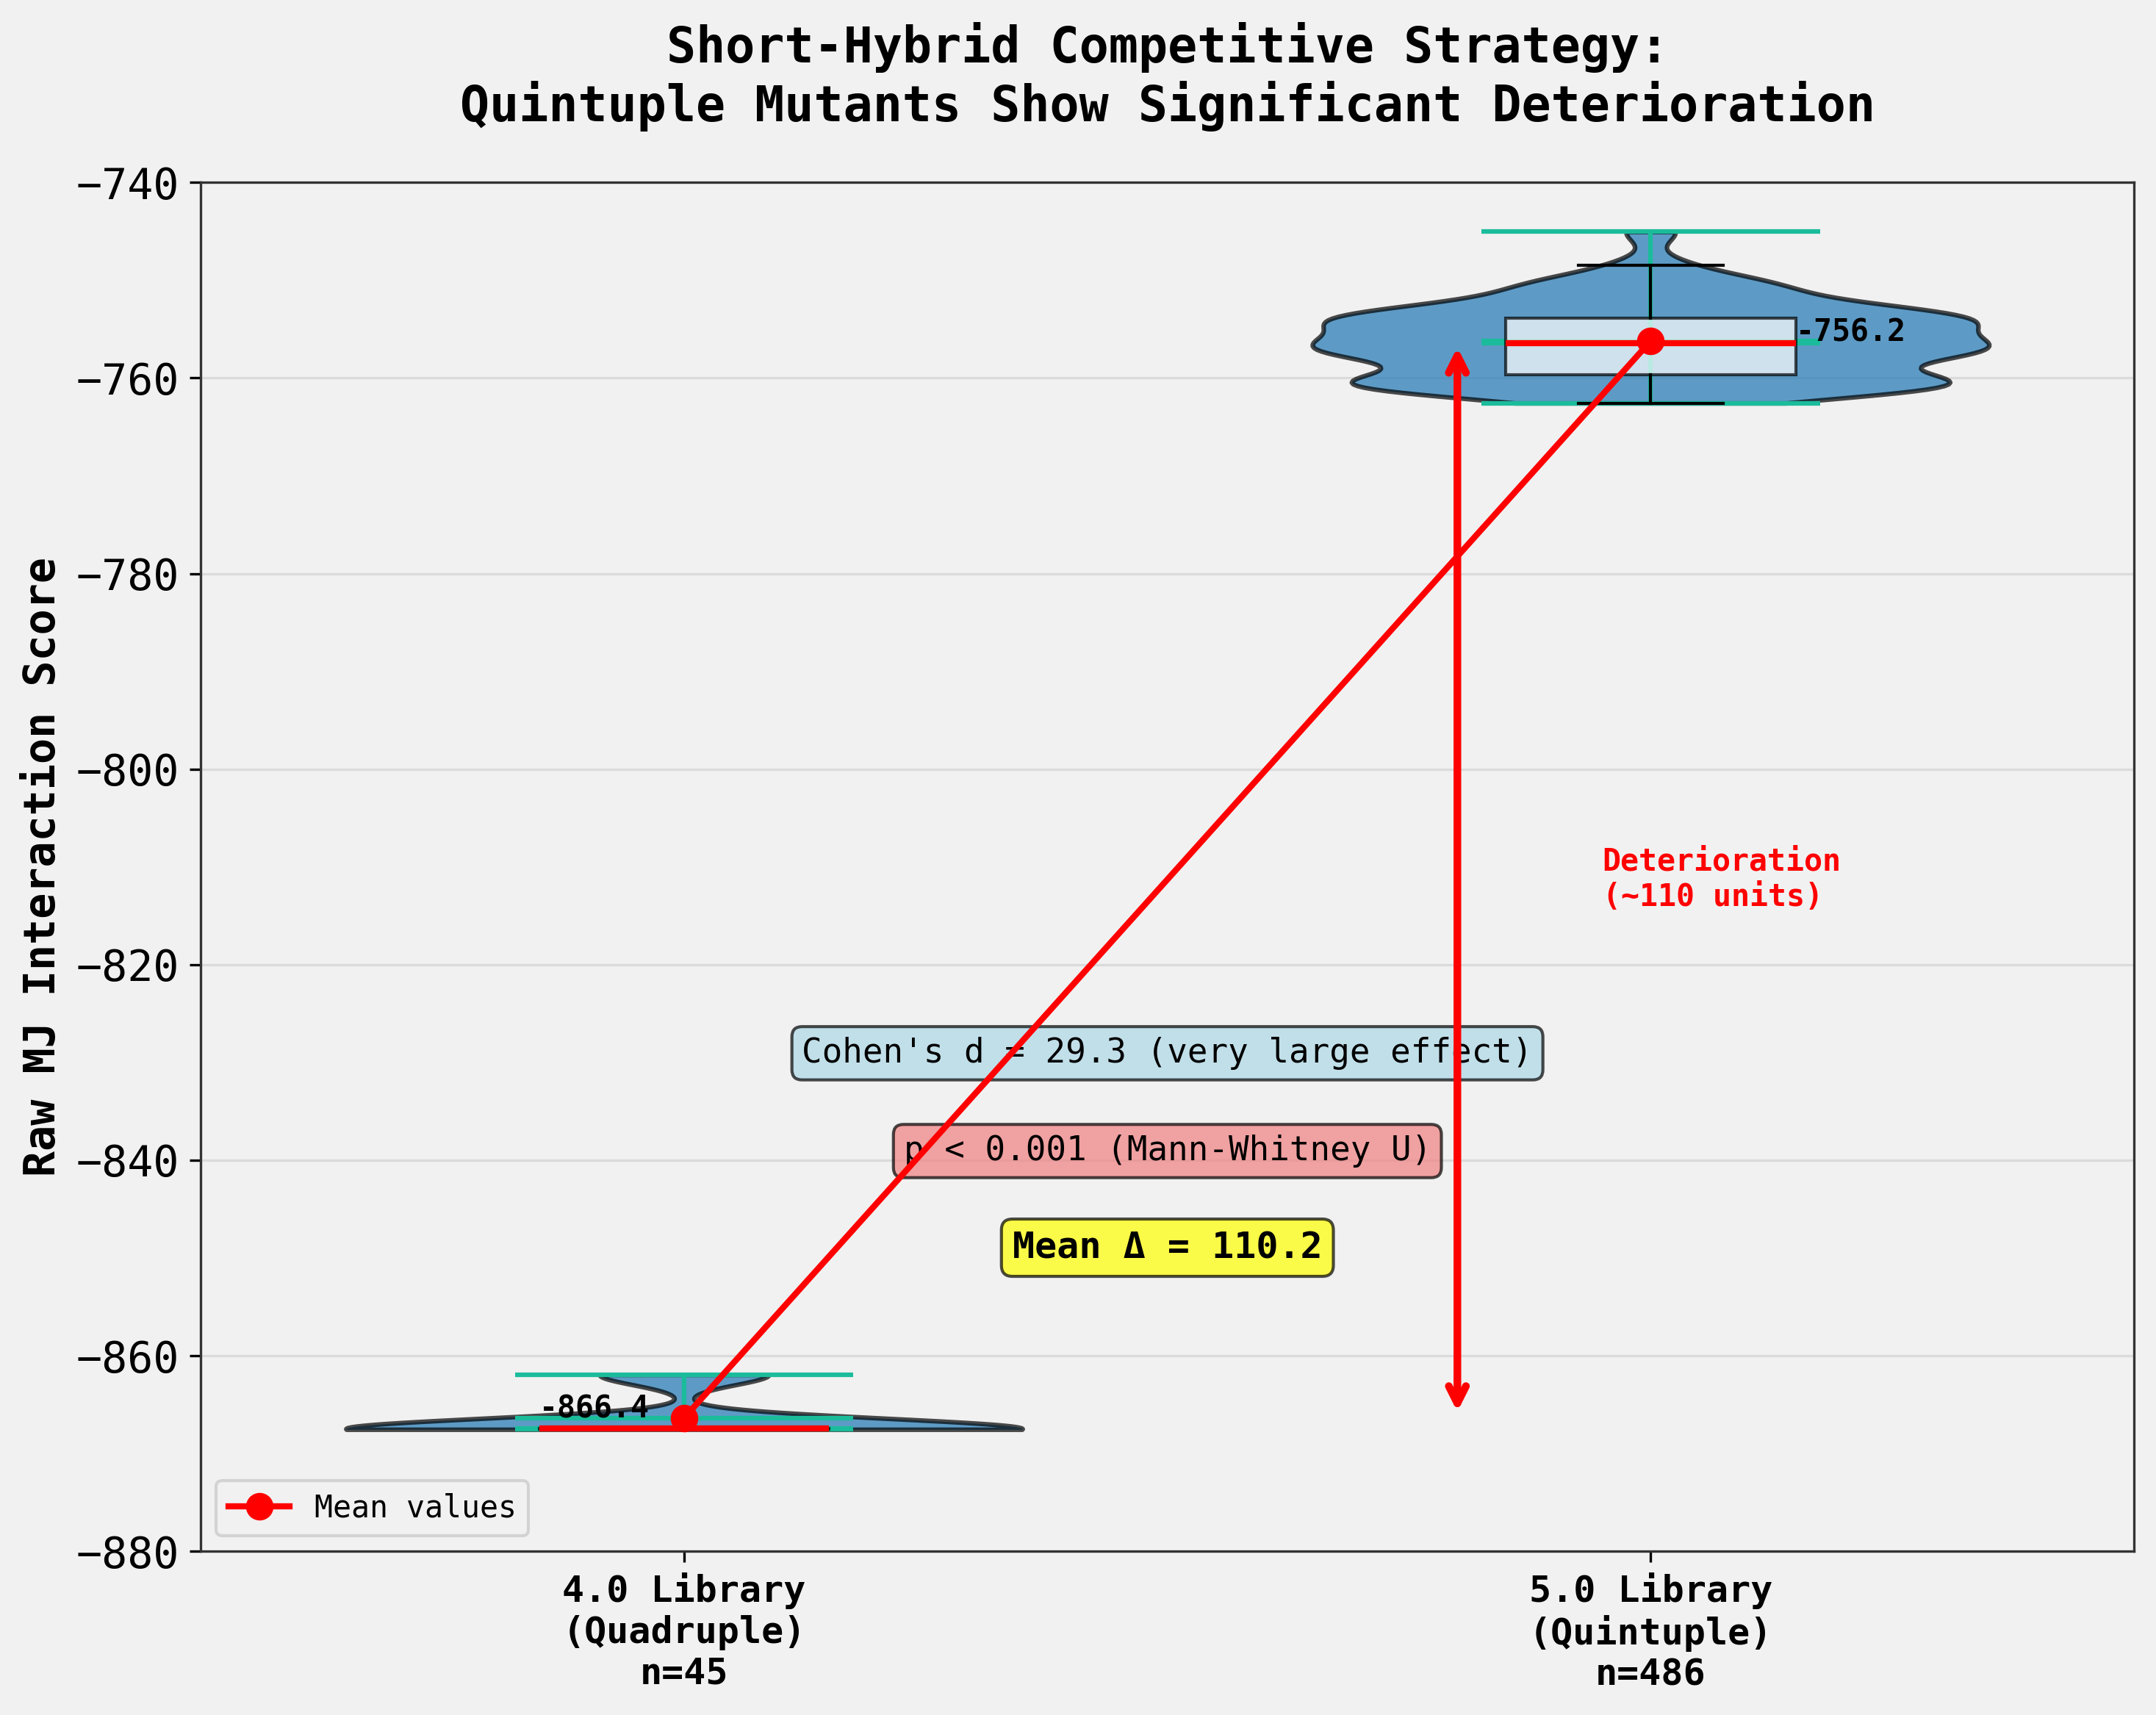


SUMMARY OF KEY FINDING:
The Short-Hybrid Competitive 5.0 strategy FAILED to improve upon 4.0.
Adding a 5th conservative mutation resulted in a massive deterioration of ~110 MJ units.
This indicates that the iterative mutagenesis strategy has reached its limit.
The hypothesis that a 5th mutation would yield 'statistically significant improvement' is REJECTED.


In [ ]:

# Step 16: Create a comprehensive visualization summarizing the key finding
import matplotlib.pyplot as plt

# Create a single-column figure with the key comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Prepare data for violin plot
data_to_plot = [parent_motif_scores_all, child_scores_all]
labels = ['4.0 Library\n(Quadruple)\nn=45', '5.0 Library\n(Quintuple)\nn=486']

# Create violin plot
parts = ax.violinplot(data_to_plot, positions=[1, 2], showmeans=True, showmedians=True, widths=0.7)

# Customize colors
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_alpha(0.7)
    pc.set_edgecolor('black')
    pc.set_linewidth(1.5)

# Add box plots overlay for clearer statistics
bp = ax.boxplot(data_to_plot, positions=[1, 2], widths=0.3, patch_artist=True,
                showfliers=False, medianprops=dict(color='red', linewidth=2))

for patch in bp['boxes']:
    patch.set_facecolor('white')
    patch.set_alpha(0.7)

# Add labels and styling
ax.set_xticks([1, 2])
ax.set_xticklabels(labels, fontsize=12, fontweight='bold')
ax.set_ylabel('Raw MJ Interaction Score', fontsize=14, fontweight='bold')
ax.set_title('Short-Hybrid Competitive Strategy:\nQuintuple Mutants Show Significant Deterioration', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, axis='y')
ax.set_axisbelow(True)

# Add horizontal line at 0 for reference
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Add statistical annotations
ax.text(1.5, -850, f'Mean Δ = {mean_child - mean_parent:.1f}', 
        ha='center', fontsize=12, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

ax.text(1.5, -840, f'p < 0.001 (Mann-Whitney U)', 
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

ax.text(1.5, -830, f"Cohen's d = {cohens_d:.1f} (very large effect)", 
        ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))

# Add annotations for means
ax.plot([1, 2], [mean_parent, mean_child], 'ro-', linewidth=2, markersize=8, 
        label='Mean values', zorder=10)
ax.text(0.85, mean_parent, f'{mean_parent:.1f}', fontsize=10, fontweight='bold')
ax.text(2.15, mean_child, f'{mean_child:.1f}', fontsize=10, fontweight='bold')

# Add arrow showing deterioration
ax.annotate('', xy=(1.8, mean_child), xytext=(1.8, mean_parent),
            arrowprops=dict(arrowstyle='<->', color='red', linewidth=2.5))
ax.text(1.95, (mean_parent + mean_child)/2, 'Deterioration\n(~110 units)', 
        fontsize=10, fontweight='bold', color='red', va='center')

ax.legend(loc='lower left', fontsize=10)

# Set y-axis limits to focus on the data
ax.set_ylim(-880, -740)

plt.tight_layout()
plt.savefig('competitive_5.0_vs_4.0_comparison.png', dpi=300, bbox_inches='tight')
print("\nFigure saved as 'competitive_5.0_vs_4.0_comparison.png'")
plt.show()

print("\n" + "="*80)
print("SUMMARY OF KEY FINDING:")
print("="*80)
print(f"The Short-Hybrid Competitive 5.0 strategy FAILED to improve upon 4.0.")
print(f"Adding a 5th conservative mutation resulted in a massive deterioration of ~110 MJ units.")
print(f"This indicates that the iterative mutagenesis strategy has reached its limit.")
print(f"The hypothesis that a 5th mutation would yield 'statistically significant improvement' is REJECTED.")


In [ ]:

# Additional analysis: Let's investigate WHY this happened
# Check what the 5th mutations actually were and their effect

print("Detailed analysis of 5th mutation effects:")
print("="*80)

# Group by the type of 5th mutation
mutation_effects = df_5_0.groupby(['Fifth_Original_AA', 'Fifth_New_AA']).agg({
    'MJ_Score': ['count', 'mean', 'min', 'max']
}).round(2)

print("\nMJ Score effects by mutation type:")
print(mutation_effects)

# Check which positions were mutated
print("\n\nMJ Score effects by mutated position:")
position_effects = df_5_0.groupby('Fifth_Mutation_Position').agg({
    'MJ_Score': ['count', 'mean', 'min', 'max'],
    'Fifth_Original_AA': lambda x: x.mode()[0] if len(x) > 0 else None
}).round(2)
print(position_effects)

# Compare to the 4.0 parent scores
print("\n\nKey insight:")
print(f"The best 5.0 design has MJ score: {df_5_0['MJ_Score'].min():.2f}")
print(f"The best 4.0 parent has MJ score: {np.min(parent_scores):.2f}")
print(f"Deterioration even in the BEST case: {df_5_0['MJ_Score'].min() - np.min(parent_scores):.2f} units")
print("\nThis demonstrates that the 4.0 library had already reached optimal MJ scores,")
print("and ANY additional mutation - even conservative ones - damages the binding interface.")


Detailed analysis of 5th mutation effects:

MJ Score effects by mutation type:
                               MJ_Score                        
                                  count    mean     min     max
Fifth_Original_AA Fifth_New_AA                                 
D                 E                   9 -749.97 -749.97 -749.97
                  N                   9 -757.78 -757.78 -757.78
I                 L                  45 -759.37 -761.34 -753.91
                  M                  45 -760.59 -762.56 -755.13
                  V                  45 -755.59 -757.56 -750.13
L                 I                  45 -756.01 -757.98 -750.55
                  M                  45 -758.91 -760.88 -753.45
                  V                  45 -753.91 -755.88 -748.45
Q                 E                  36 -753.44 -754.05 -752.83
                  K                  36 -754.51 -755.12 -753.90
                  R                  36 -757.17 -757.78 -756.56
W                 F      